# Figure 2.b - Supervised model performance

Goals : 

- Show that 3D models outperform usual 2D models

In [1]:
import numpy as np
from tifffile import imread
import sys
import numpy as np

import pyclesperanto_prototype as cle
from stardist.matching import matching_dataset
sys.path.append("../..")

from utils import *
from plots import *
print("Used GPU: ", cle.get_device())
show_params()
#################
SAVE_PLOTS_AS_PNG = False
SAVE_PLOTS_AS_SVG = True

Used GPU:  <Intel(R) UHD Graphics 620 on Platform: Intel(R) OpenCL (1 refs)>
Plot parameters (set in plots.py) : 
- COLORMAP : ██████████
- DPI : 200
- Data path : C:\Users\Cyril\Desktop\Code\CELLSEG_BENCHMARK
- Font size : 20
- Title font size : 25.0
- Label font size : 20.0


In [2]:
%load_ext autoreload
%autoreload 2

## Data

In [3]:
data_path = DATA_PATH / "RESULTS/SUPERVISED_PERF_FIG/INFERENCE"
fold1_path = data_path / "fold1"
fold2_path = data_path / "fold2"
fold3_path = data_path / "fold3"

def get_fold_data(fold_path):
    return [imread(f) for f in fold_path.glob("*.tif") if "label" not in f.name], [imread(f) for f in fold_path.glob("*.tif") if "label" in f.name]

images = []
GT_labels = []
for fold in [fold1_path, fold2_path, fold3_path]:
    im, GT_lab = get_fold_data(fold)
    images.append(im[0])
    GT_labels.append(GT_lab[0])

In [4]:
fold_paths = [fold1_path, fold2_path, fold3_path]

def get_predictions(path):
    return [imread(f) for f in path.glob("*.tif")]
#################
swin_paths = [f / "Swin" for f in fold_paths]
segresnet_paths = [f / "SegResNet" for f in fold_paths]
#################
cellpose_paths = [f / "Cellpose" for f in fold_paths]
stardist_paths = [f / "stardist" for f in fold_paths]

swin_predictions = [get_predictions(p)[0] for p in swin_paths]
segresnet_predictions = [get_predictions(p)[0] for p in segresnet_paths]
cellpose_predictions = [get_predictions(p)[0] for p in cellpose_paths]
stardist_predictions = [get_predictions(p)[0] for p in stardist_paths]

## Computations

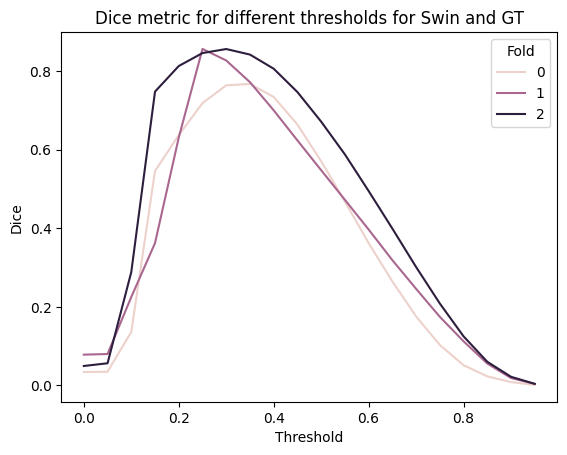

In [5]:
thresh = np.arange(0, 1, 0.05)
rows = []
for t in thresh:
    for i, (gt, pred) in enumerate(zip(GT_labels, segresnet_predictions)):
        dices_row = {"Threshold": t, "Fold": i, "Dice": dice_coeff(
            np.where(gt > 0, 1, 0),
            np.where(pred > t, 1, 0)
            )}
        rows.append(dices_row)
        
dices_df = pd.DataFrame(rows)

sns.lineplot(data=dices_df, x="Threshold", y="Dice", hue="Fold")
plt.title("Dice metric for different thresholds for Swin and GT")
plt.show()

In [6]:
dices_df.groupby(["Threshold"]).Dice.mean()

Threshold
0.00    0.054155
0.05    0.057255
0.10    0.216817
0.15    0.552204
0.20    0.693733
0.25    0.807195
0.30    0.815863
0.35    0.793930
0.40    0.747087
0.45    0.678291
0.50    0.596850
0.55    0.509753
0.60    0.418251
0.65    0.327816
0.70    0.241233
0.75    0.162271
0.80    0.096478
0.85    0.046514
0.90    0.016642
0.95    0.003278
Name: Dice, dtype: float64

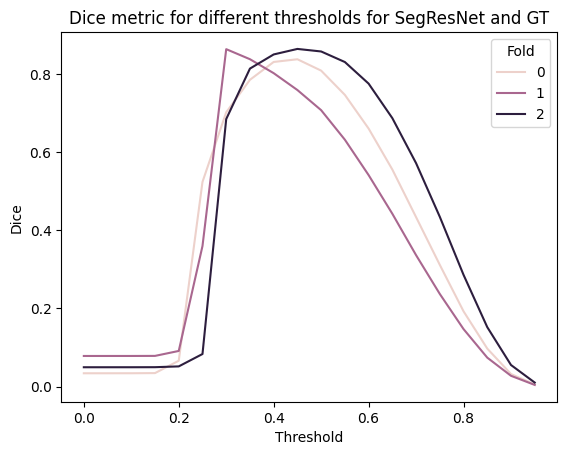

In [7]:
thresh = np.arange(0, 1, 0.05)
rows = []
for t in thresh:
    for i, (gt, pred) in enumerate(zip(GT_labels, swin_predictions)):
        dices_row = {"Threshold": t, "Fold": i, "Dice": dice_coeff(
            np.where(gt > 0, 1, 0),
            np.where(pred > t, 1, 0)
            )}
        rows.append(dices_row)
        
dices_df = pd.DataFrame(rows)

sns.lineplot(data=dices_df, x="Threshold", y="Dice", hue="Fold")
plt.title("Dice metric for different thresholds for Swin and GT")
plt.show()

In [8]:
dices_df.groupby("Threshold").Dice.mean()

Threshold
0.00    0.054155
0.05    0.054156
0.10    0.054182
0.15    0.054416
0.20    0.069865
0.25    0.322344
0.30    0.750012
0.35    0.812172
0.40    0.827548
0.45    0.820174
0.50    0.791124
0.55    0.736239
0.60    0.658966
0.65    0.561598
0.70    0.447305
0.75    0.327757
0.80    0.208729
0.85    0.107967
0.90    0.038529
0.95    0.006889
Name: Dice, dtype: float64

In [9]:
swin_thresholded = [np.where(swin > 0.4, swin, 0) for swin in swin_predictions]
segresnet_thresholded = [np.where(segresnet > 0.3, segresnet, 0) for segresnet in segresnet_predictions]

In [10]:
swin_instance = []
segresnet_instance = []

for i in range(len(fold_paths)):
    swin_instance.append(np.array(
        cle.voronoi_otsu_labeling(swin_thresholded[i], spot_sigma=0.65, outline_sigma=0.65))
                         )
    segresnet_instance.append(np.array(
        cle.voronoi_otsu_labeling(segresnet_thresholded[i], spot_sigma=0.65, outline_sigma=0.65))
                              )

In [11]:
from tifffile import imwrite
for i in range(len(fold_paths)):
    save_folder = data_path / f"fold{i+1}" / "processed"
    save_folder.mkdir(exist_ok=True, parents=False)
    imwrite(save_folder / "swin_instance.tif", swin_instance[i])
    imwrite(save_folder / "segresnet_instance.tif", segresnet_instance[i])

## Plots

In [12]:
taus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

predictions = [
   swin_instance,
   segresnet_instance,
   cellpose_predictions,
   stardist_predictions,
   ]
names = ["SwinUNetR - Ours",
         "SegResNet - Ours",
         "Cellpose",
         "Stardist"
         ]

model_stats = []
model_ref_name = []
fold_ref = []

for j, fold in enumerate(fold_paths):
    print("Fold ", j+1)
    for i, p in enumerate(predictions):
        print(f"Validating on {names[i]}")
        stats = [matching_dataset(
            GT_labels[j], p[j], thresh=t, show_progress=False
            ) for t in taus]
        model_stats.append(stats)
        for t in taus:
            model_ref_name.append(names[i])
            fold_ref.append(j+1)
        # uncomment for ALL plots : 
        # plot_performance(taus, stats, name=names[i])
        print("*"*20)

Fold  1
Validating on SwinUNetR - Ours
********************
Validating on SegResNet - Ours
********************
Validating on Cellpose
********************
Validating on Stardist
********************
Fold  2
Validating on SwinUNetR - Ours
********************
Validating on SegResNet - Ours
********************
Validating on Cellpose
********************
Validating on Stardist
********************
Fold  3
Validating on SwinUNetR - Ours
********************
Validating on SegResNet - Ours
********************
Validating on Cellpose
********************
Validating on Stardist
********************


In [13]:
dfs = [dataset_matching_stats_to_df(s) for s in model_stats]
df = pd.concat(dfs)
df["Model"] = model_ref_name
df["Fold"] = fold_ref
df["thresh"] = df.index
df.set_index(["Model", "Fold", "thresh"], inplace=True)
df

criterion    fp    tp    fn  precision    recall  \
Model            Fold thresh                                                    
SwinUNetR - Ours 1    0.1          iou   724  3017   368   0.806469  0.891285   
                      0.2          iou   740  3001   384   0.802192  0.886558   
                      0.3          iou   781  2960   425   0.791232  0.874446   
                      0.4          iou   810  2931   454   0.783480  0.865879   
                      0.5          iou   892  2849   536   0.761561  0.841654   
...                                ...   ...   ...   ...        ...       ...   
Stardist         3    0.5          iou  6486  1147  5762   0.150269  0.166015   
                      0.6          iou  7179   454  6455   0.059479  0.065711   
                      0.7          iou  7415   218  6691   0.028560  0.031553   
                      0.8          iou  7500   133  6776   0.017424  0.019250   
                      0.9          iou  7576    57  6852   0.007468  0.008250   

                              accuracy        f1  n_true  n_pred  \
Model            Fold thresh                                       
SwinUNetR - Ours 1    0.1     0.734242  0.846758    3385    3741   
                      0.2     0.727515  0.842268    3385    3741   
                      0.3     0.710514  0.830761    3385    3741   
                      0.4     0.698689  0.822621    3385    3741   
                      0.5     0.666121  0.799607    3385    3741   
...                                ...       ...     ...     ...   
Stardist         3    0.5     0.085629  0.157750    6909    7633   
                      0.6     0.032226  0.062440    6909    7633   
                      0.7     0.015219  0.029982    6909    7633   
                      0.8     0.009230  0.018292    6909    7633   
                      0.9     0.003935  0.007839    6909    7633   

                              mean_true_score  mean_matched_score  \
Model            Fold thresh                                        
SwinUNetR - Ours 1    0.1            0.705704            0.791782   
                      0.2            0.705090            0.795311   
                      0.3            0.702058            0.802860   
                      0.4            0.699128            0.807420   
                      0.5            0.688671            0.818235   
...                                       ...                 ...   
Stardist         3    0.5            0.101371            0.610610   
                      0.6            0.048145            0.732678   
                      0.7            0.026352            0.835162   
                      0.8            0.017269            0.897081   
                      0.9            0.008236            0.998246   

                              panoptic_quality  by_image  
Model            Fold thresh                              
SwinUNetR - Ours 1    0.1             0.670448     False  
                      0.2             0.669865     False  
                      0.3             0.666984     False  
                      0.4             0.664201     False  
                      0.5             0.654266     False  
...                                        ...       ...  
Stardist         3    0.5             0.096324     False  
                      0.6             0.045748     False  
                      0.7             0.025040     False  
                      0.8             0.016409     False  
                      0.9             0.007826     False  

[108 rows x 14 columns]

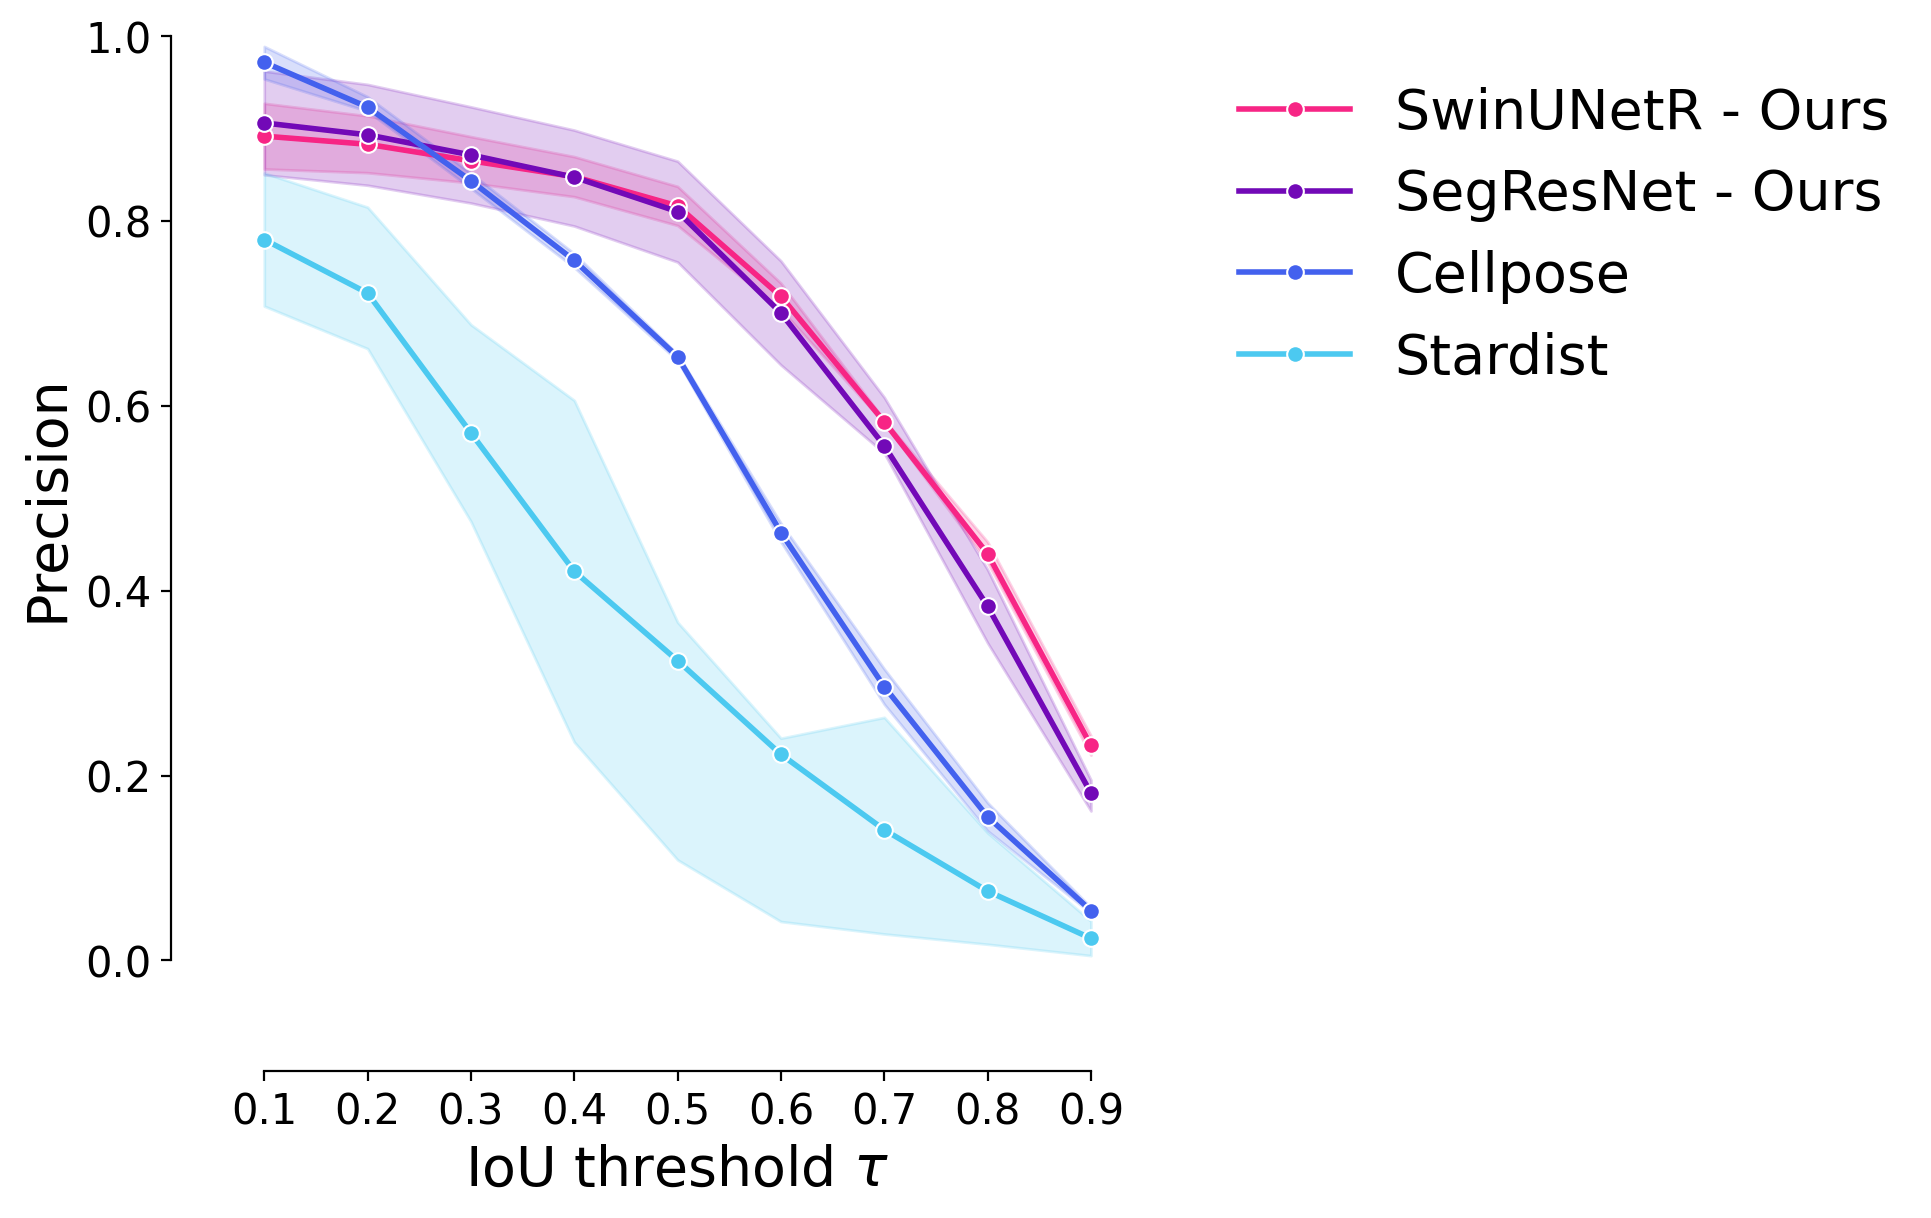

In [14]:
plot_stat_comparison_fold(df, stat="precision")
if SAVE_PLOTS_AS_PNG:
    plt.savefig("precision_comparison_fold.png", bbox_inches = "tight")
if SAVE_PLOTS_AS_SVG:
    plt.savefig("precision_comparison_fold.svg", bbox_inches = "tight")

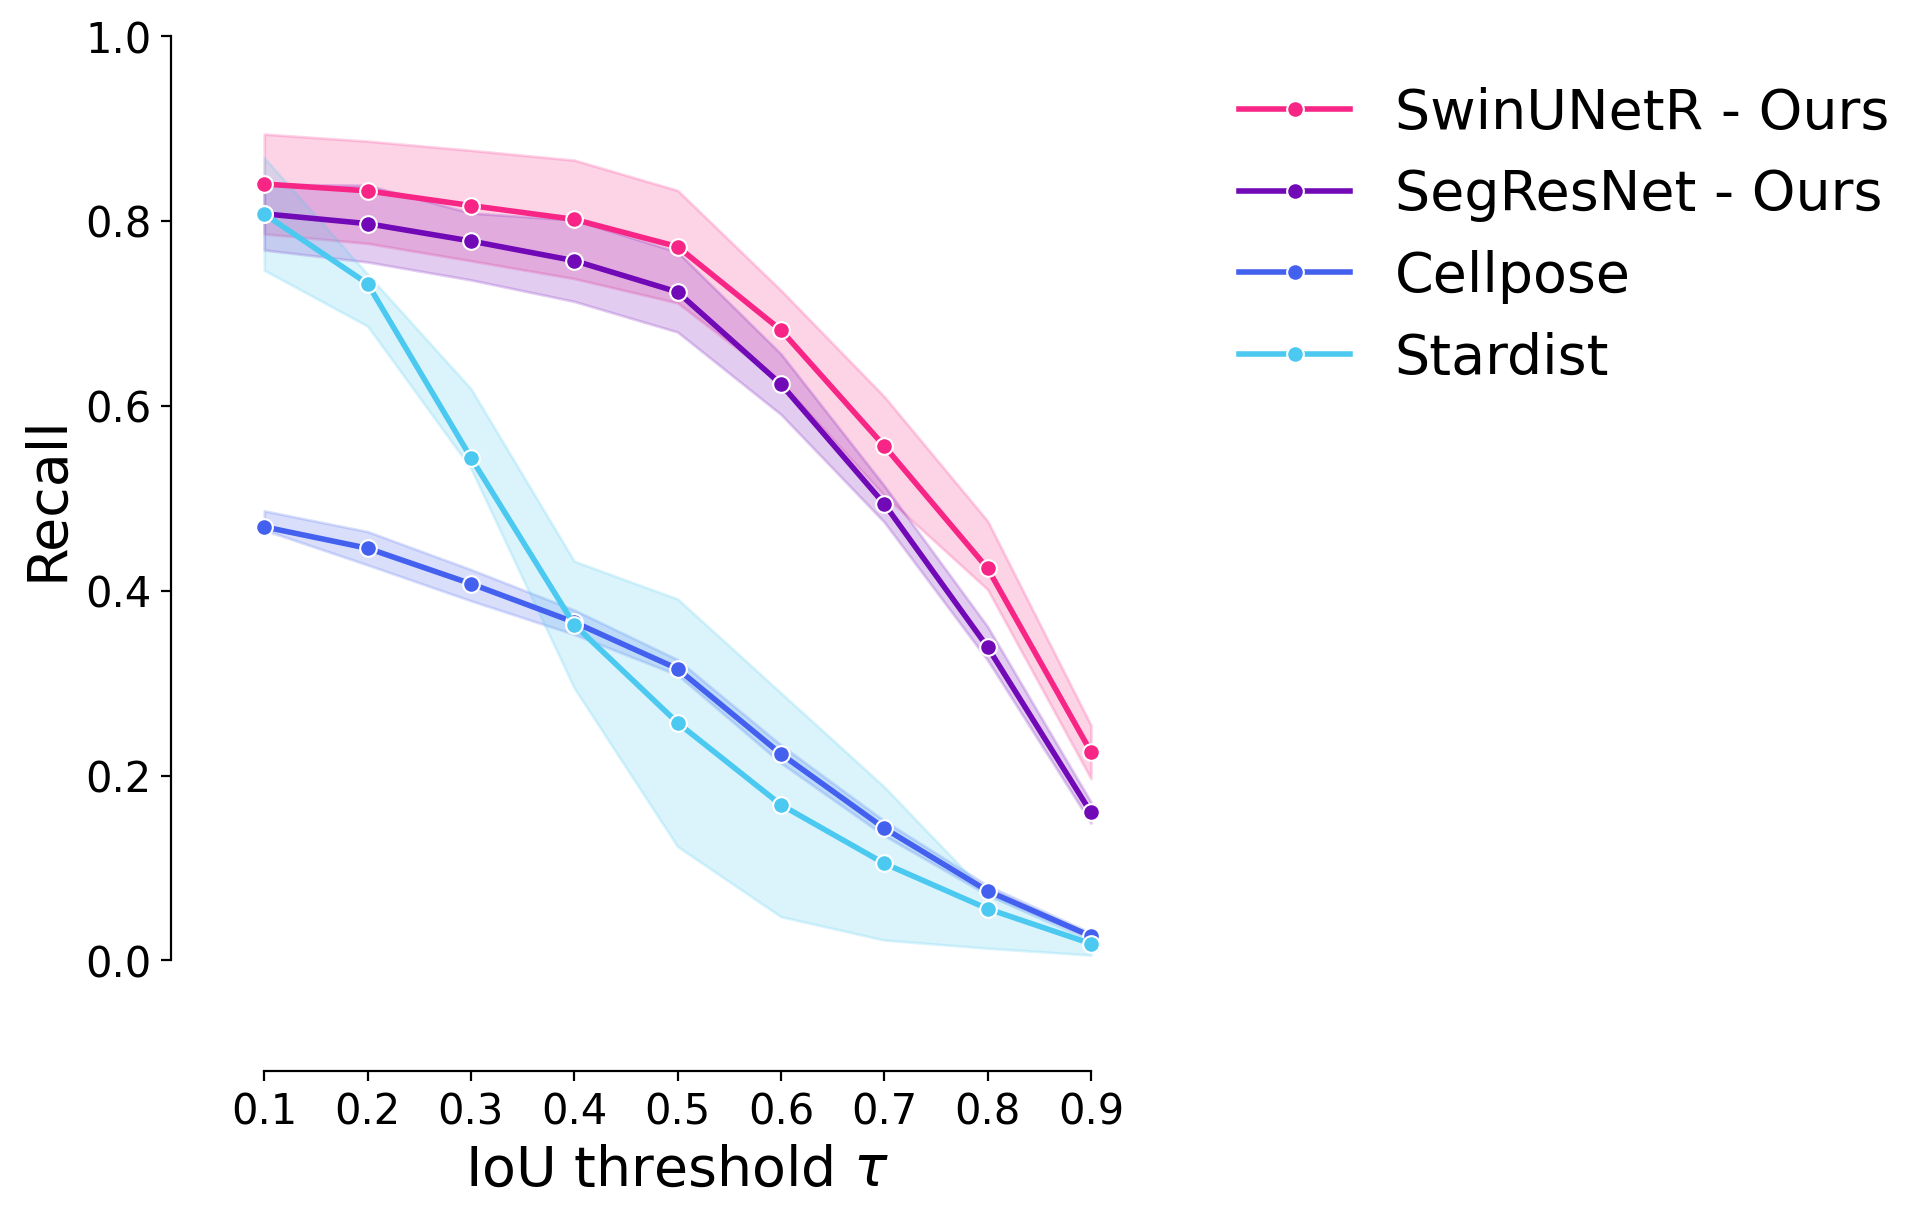

In [15]:
plot_stat_comparison_fold(df, stat="recall")
if SAVE_PLOTS_AS_PNG:
    plt.savefig("recall_comparison_fold.png", bbox_inches = "tight")
if SAVE_PLOTS_AS_SVG:
    plt.savefig("recall_comparison_fold.svg", bbox_inches = "tight")

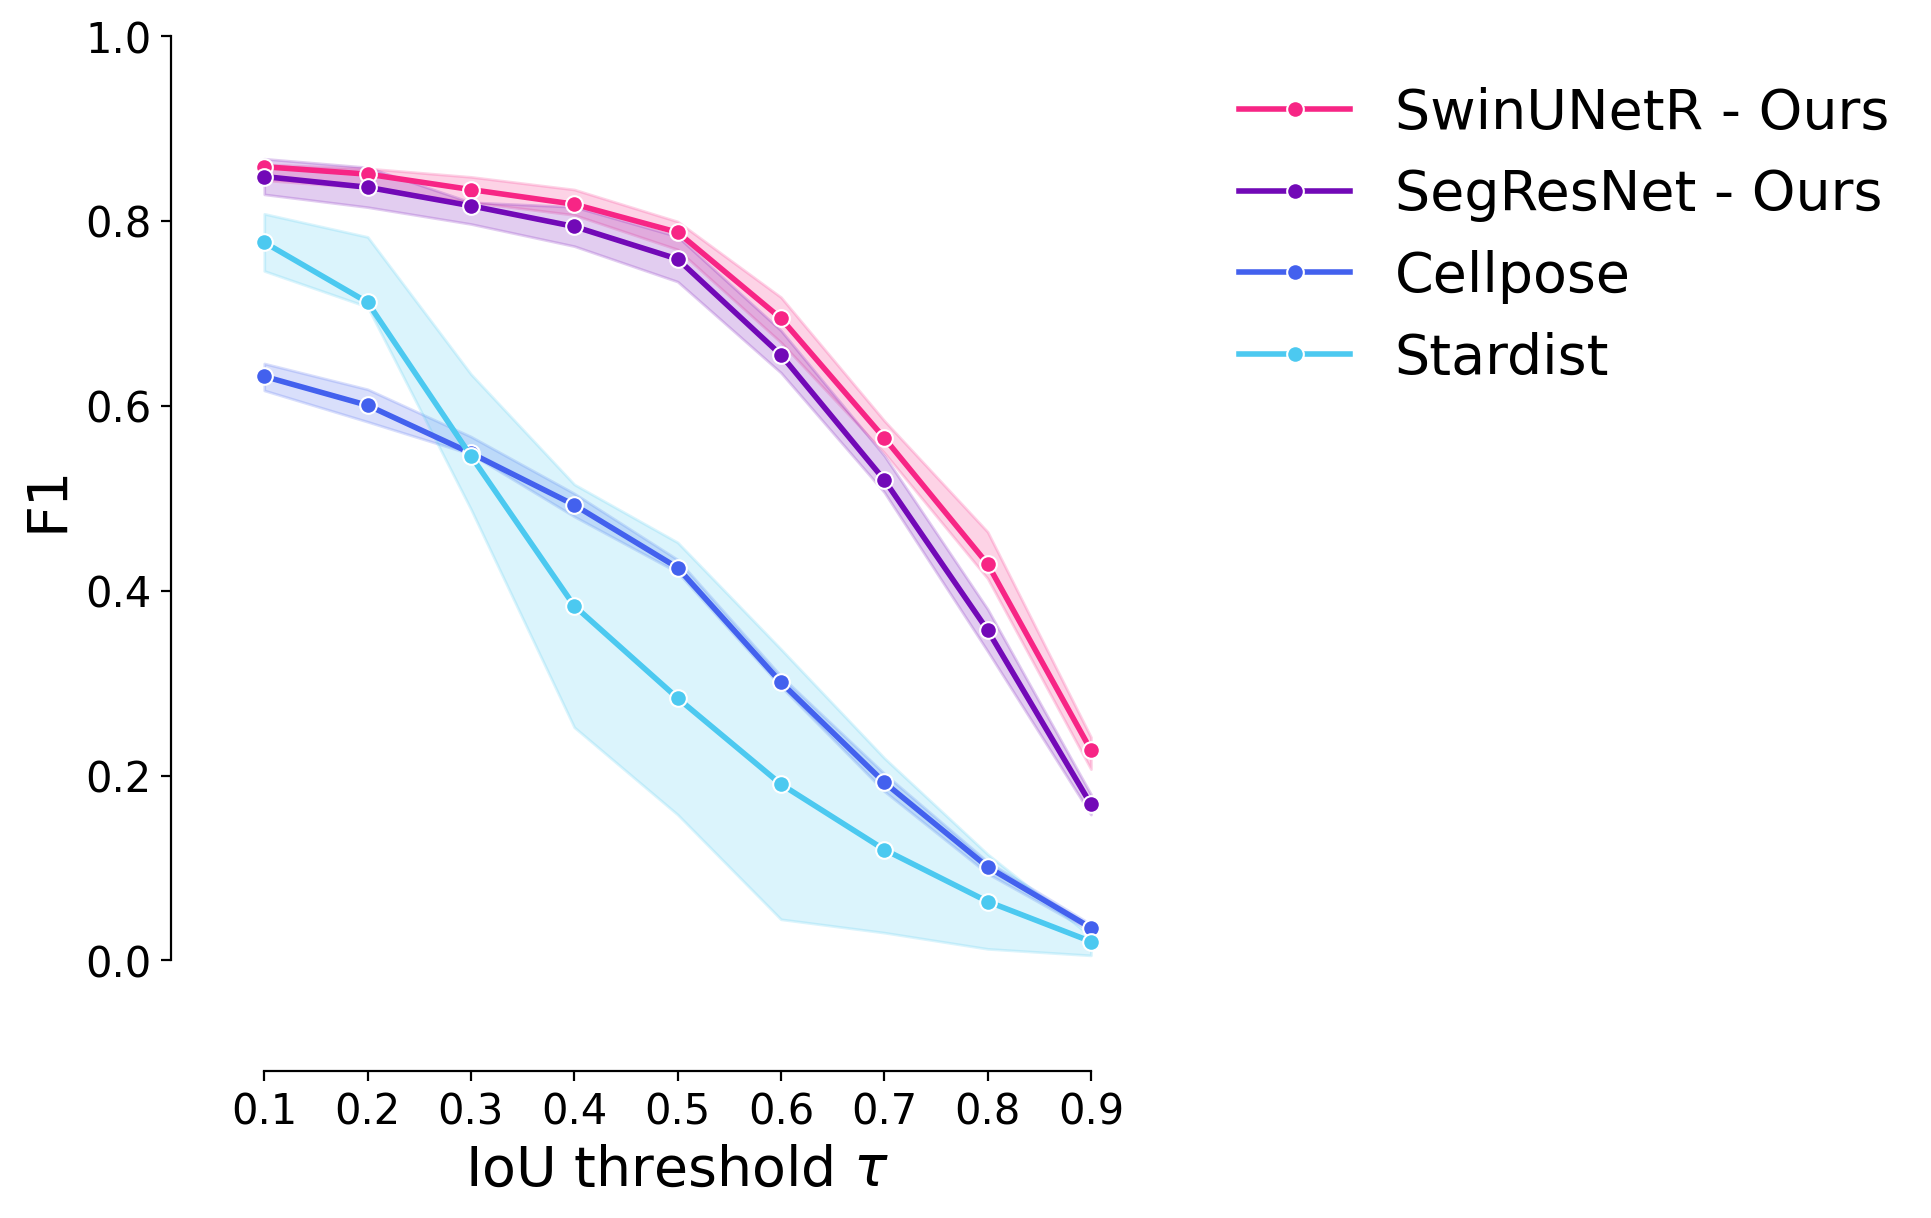

In [16]:
plot_stat_comparison_fold(df, stat="f1")
if SAVE_PLOTS_AS_PNG:
    plt.savefig("f1_comparison_fold.png", bbox_inches = "tight")
if SAVE_PLOTS_AS_SVG:
    plt.savefig("f1_comparison_fold.svg", bbox_inches = "tight")

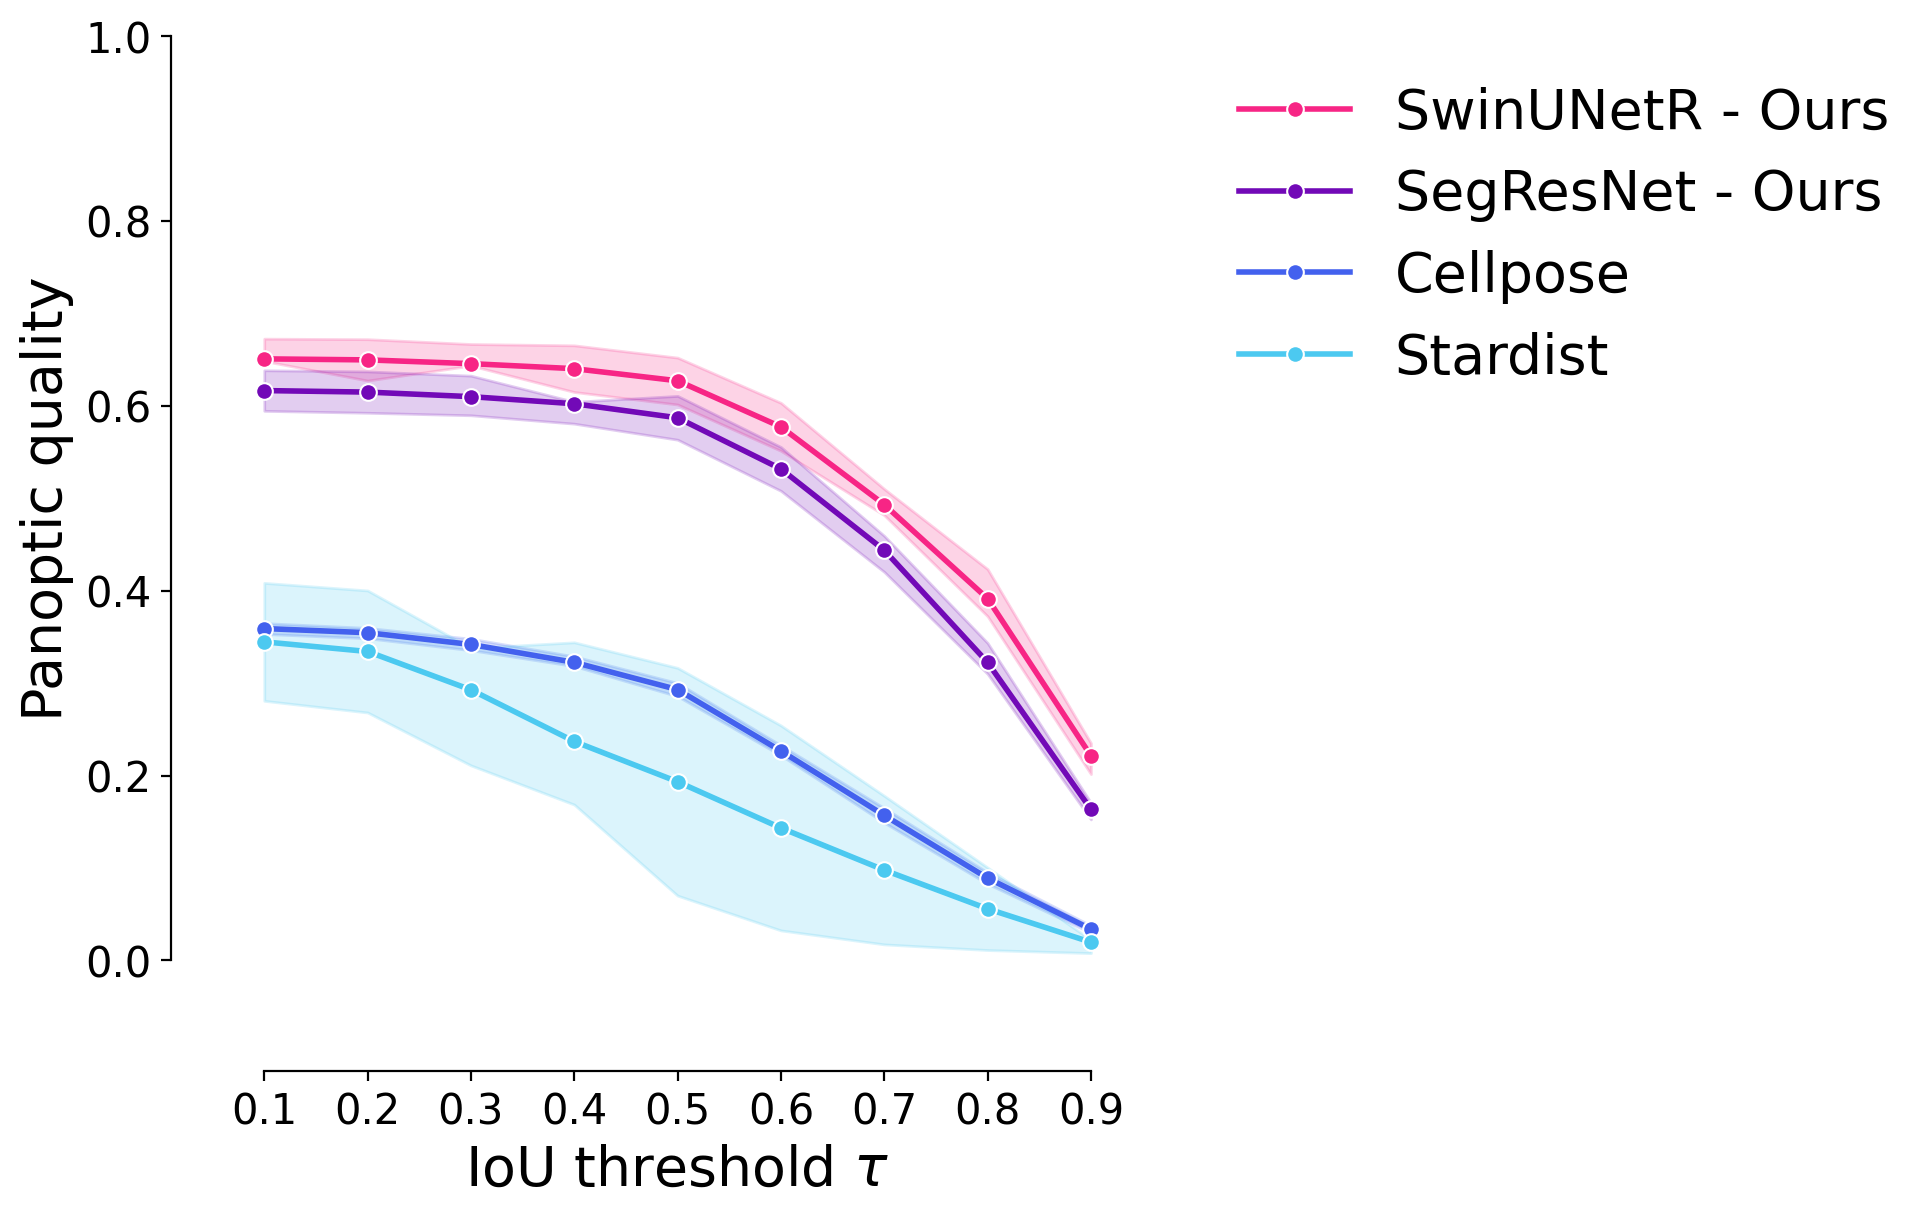

In [17]:
plot_stat_comparison_fold(df, stat="panoptic_quality")
if SAVE_PLOTS_AS_PNG:
    plt.savefig("panoptic_quality_comparison_fold.png", bbox_inches = "tight")
if SAVE_PLOTS_AS_SVG:
    plt.savefig("panoptic_quality_comparison_fold.svg", bbox_inches = "tight")